# Description

- This is an analysis notebook

## Features

## todo:
- my_positions
    - calculate approx product price per turn
    - calculate total inventory value + total net worth (aka pnl)
- visualize book

In [1]:
from IPython.display import display, HTML
import ipywidgets as widgets
from ipywidgets import interact
display(HTML("<style>.container { width:75% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import json
import copy
import traceback

import matplotlib as mpl
from matplotlib import pyplot as plt

In [3]:
from log_parser import process_file, process_file_jasper



# parameters

In [4]:
# _fname = "../replays/local.log"
# _fname = "../replays/day1-log15.log"
_fname = "../replays/day1-log30.log"
_time_step = 100
_max_time = 100000
_num_close_turns = 30
_symbols = ["BANANAS", "PEARLS"]
_products = ["BANANAS", "PEARLS"]

print("_fname", _fname)


_fname ../replays/day1-log30.log


# pre processing

In [5]:
# load data from file

obj = process_file(_fname, start_sep="__game_state_start", end_sep="__game_state_end")

raw_df = pd.DataFrame(obj)

listings = pd.DataFrame(raw_df["listings"][0])
# products = set(listings.T["product"])
raw_df = raw_df.drop("listings", axis=1)
raw_df = raw_df.rename({
    "timestamp": "time",
    "order_depths": "book",
}, axis=1)

missing_times = set([i for i in range(0, _max_time, _time_step)]) - set(raw_df["time"])
print("num missing_times", len(missing_times))
print("missing_times", sorted(missing_times))


Reading from input file ../replays/day1-log30.log
num missing_times 2
missing_times [24100, 54000]


In [6]:
# load order info from file
obj = process_file(_fname, start_sep="__turn_end_start", end_sep="__turn_end_end")
raw_records = pd.DataFrame(obj)

missing_times = set([i for i in range(0, _max_time, _time_step)]) - set(raw_records["time"])
print("num missing_times", len(missing_times))
print("missing_times", sorted(missing_times))

Reading from input file ../replays/day1-log30.log
num missing_times 2
missing_times [24100, 54000]


### add turns

In [7]:
# add turns (vs time)

all_times = raw_df["time"]
turn2time_map = all_times.to_dict()
time2turn_map = {v: k for k, v in turn2time_map.items()}
raw_df["turn"] = raw_df["time"].map(time2turn_map)

raw_df.index = raw_df["turn"]

### ref_stat_df
- the EMA values that were calculated during the program
- quote_mids during program
- fair valeus calculated during program

In [8]:
# ref_emas contains EMA values that were used during the program
ref_emas = raw_records["best_emas"].apply(pd.Series).round(2)
ref_emas = pd.concat([ref_emas, raw_records["time"]], axis=1)

ref_ema_df = ref_emas.melt(id_vars=["time"], var_name="symbol", value_name="ref_ema") \
                        .sort_values(by=["time", "symbol"]) \
                        .reset_index(drop=True)


In [9]:
# large_quote_mid
quote_mids = raw_records["quote_mids"].apply(pd.Series)
quote_mids = pd.concat([quote_mids, raw_records["time"]], axis=1)

quote_mid_df = quote_mids.melt(id_vars=["time"], var_name="symbol", value_name="quote_mid") \
                        .sort_values(by=["time", "symbol"]) \
                        .reset_index(drop=True)


# large_quote_mid
use_quote_mids = raw_records["use_quote_mids"].apply(pd.Series)
use_quote_mids = pd.concat([use_quote_mids, raw_records["time"]], axis=1)

use_quote_mid_df = use_quote_mids.melt(id_vars=["time"], var_name="symbol", value_name="use_quote_mid") \
                        .sort_values(by=["time", "symbol"]) \
                        .reset_index(drop=True)



In [10]:
fair_values = raw_records["fair_values"].apply(pd.Series)
fair_values = pd.concat([fair_values, raw_records["time"]], axis=1)

fair_value_df = fair_values.melt(id_vars=["time"], var_name="symbol", value_name="fair_value") \
                        .sort_values(by=["time", "symbol"]) \
                        .reset_index(drop=True)


In [11]:
ref_stat_df = pd.concat([
    ref_ema_df.set_index(["time", "symbol"]),
    quote_mid_df.set_index(["time", "symbol"]),
    use_quote_mid_df.set_index(["time", "symbol"]),
    fair_value_df.set_index(["time", "symbol"]),
], axis=1).reset_index()

In [12]:
ref_stat_df

,time,symbol,ref_ema,quote_mid,use_quote_mid,fair_value
0,0,BANANAS,4896.00,4895.5,True,4895.5
1,0,PEARLS,10001.50,10000.0,True,10000.0
2,100,BANANAS,4896.14,4895.0,True,4895.0
3,100,PEARLS,10001.64,10000.0,True,10000.0
4,200,BANANAS,4896.08,4895.5,True,4895.5
...,...,...,...,...,...,...
1991,99700,PEARLS,9999.40,10000.0,True,10000.0
1992,99800,BANANAS,4893.56,4893.5,True,4893.5
1993,99800,PEARLS,9999.36,10000.0,True,10000.0
1994,99900,BANANAS,4893.55,4893.0,True,4893.0


### book_tops

#### modify raw_df["book"] to be all ints

In [13]:
# modify raw_df["book"] to be all ints
raw_df["book"] = raw_df["book"].apply(lambda x: {
    sym: {
        typ: {
            int(k) : v for k, v in orders.items()
        }
        for typ, orders in all_orders.items()
    }
    for sym, all_orders in x.items()
})

In [14]:
book_data = []
book_cols = []

cmp = lambda k : tuple([int(k[0]), int(k[1])])

for sym in _symbols:
    ### buys
    col = raw_df["book"].apply(lambda x: x[sym])
    # convert dicts into int -> int
    col = col.apply(lambda x : [(int(k), v) for k, v in x["buy_orders"].items()])
    col = col.apply(lambda x : sorted(x, reverse=True))
    col = col.apply(lambda x : x[0][0] if len(x) > 0 else np.nan).astype(float)
    
    book_data += [col]
    book_cols += [f"{sym}_best_buy"]
    
    
    ### sells
    col = raw_df["book"].apply(lambda x: x[sym])
    col = col.apply(lambda x : [(int(k), v) for k, v in x["sell_orders"].items()])
    col = col.apply(lambda x : sorted(x, reverse=False))
    col = col.apply(lambda x: x[0][0] if len(x) > 0 else np.nan).astype(float)
    
    book_data += [col]
    book_cols += [f"{sym}_best_sell"]
    
    
book_tops = pd.concat(book_data, axis=1)
book_tops.columns = book_cols

# all book tops
for sym in _symbols:
    book_tops[f"{sym}_mid"] = (book_tops[f"{sym}_best_buy"] + book_tops[f"{sym}_best_sell"]) / 2
    book_tops[f"{sym}_spread"] = book_tops[f"{sym}_best_sell"] - book_tops[f"{sym}_best_buy"]
    
    print("missing mids", sym, list(book_tops.index[book_tops[f"{sym}_mid"].isna()]))
    
    book_tops[f"{sym}_mid"] = book_tops[f"{sym}_mid"].bfill()
    assert book_tops[f"{sym}_spread"].all() > 0

# sort columns
book_tops = book_tops.reindex(sorted(book_tops.columns), axis=1)
book_tops["time"] = raw_df["time"]



missing mids BANANAS []
missing mids PEARLS []


In [15]:
num_data_dropna = len(book_tops.dropna())
num_data = len(book_tops)

print(f"Orig count: {num_data}")
print(f"Remaining count: {num_data_dropna}")
print(f"nan count: {num_data - num_data_dropna}")

Orig count: 998
Remaining count: 998
nan count: 0


In [16]:
book_tops

,BANANAS_best_buy,BANANAS_best_sell,BANANAS_mid,BANANAS_spread,PEARLS_best_buy,PEARLS_best_sell,PEARLS_mid,PEARLS_spread,time
turn,,,,,,,,,
0,4893.0,4899.0,4896.0,6.0,9998.0,10005.0,10001.5,7.0,0
1,4897.0,4898.0,4897.5,1.0,10002.0,10004.0,10003.0,2.0,100
2,4892.0,4899.0,4895.5,7.0,9996.0,10004.0,10000.0,8.0,200
3,4898.0,4900.0,4899.0,2.0,9995.0,10005.0,10000.0,10.0,300
4,4894.0,4896.0,4895.0,2.0,9998.0,10004.0,10001.0,6.0,400
...,...,...,...,...,...,...,...,...,...
993,4889.0,4896.0,4892.5,7.0,9995.0,9998.0,9996.5,3.0,99500
994,4889.0,4892.0,4890.5,3.0,9995.0,10005.0,10000.0,10.0,99600
995,4892.0,4896.0,4894.0,4.0,9995.0,10005.0,10000.0,10.0,99700


In [17]:
def report_issue_and_continue(condition, fail_msg):
    try:
        assert condition
    except:
        traceback.print_exc()
        display(fail_msg)

### func - flatten_trades() + mark my trades

In [18]:
def flatten_trades(raw_df, col, is_me):
    # get market trades

    data = []
    for index, row  in raw_df.iterrows():
        all_trades = list(row[col].values())
        for sym_trades in all_trades:
            for trade in sym_trades:
                trade["time"] = row["time"] # fill time
                trade["turn"] = row["turn"] # fill time
            data += sym_trades

    df = pd.DataFrame(data)
    # print(df.columns)
    df = df.rename({"timestamp": "order_time"}, axis=1)
    
    # calculate info about my trades
    df["is_me"] = is_me
    df["my_buy"] = df["buyer"] == "SUBMISSION"
    df["my_sell"] = df["seller"] == "SUBMISSION"
    df["my_quantity"] = df["quantity"] * (df["my_buy"].astype(int) - df["my_sell"].astype(int))
    df["self_trade"] = df["my_buy"] & df["my_sell"]
    
    # report self trades
    self_trades = df[df["self_trade"]]
    report_issue_and_continue( len(self_trades) == 0, self_trades)
    
    return df

### dup trade filtering -> market_trades, my_trades, trade_df

In [19]:
# get my_trades, market_trades, and trade_df (all_trades)

market_trades = flatten_trades(
    raw_df, 
    "market_trades", 
    is_me=False
).sort_values(by="time")

my_trades = flatten_trades(
    raw_df, 
    "own_trades", 
    is_me=True
).sort_values(by="time")

market_trades = market_trades.drop_duplicates(subset=["buyer", "price", "quantity", "seller", "symbol", "order_time"])
# my_trades = my_trades.drop_duplicates(subset=["buyer", "price", "quantity", "seller", "symbol", "order_time"])


# ## old filter methods
# # filter market trades (only keep those where order_time = fill_time)
# market_trades = market_trades[market_trades["time"] == market_trades["order_time"]]

# filter my_trades (only keep those where fill_time = order_time + 100)
my_trades = my_trades[my_trades["time"] <= my_trades["order_time"] + _time_step]
## end of old filter methods

trade_df = pd.concat([market_trades, my_trades])

sum_cols = ["quantity", "my_quantity"]

# aggregate quantity over similar trades
trade_df = trade_df.groupby(list(set(trade_df.columns) - set(sum_cols)))[sum_cols].sum().reset_index()[trade_df.columns]
trade_df = trade_df.sort_values(by=["time", "symbol"]).reset_index(drop=True)



trade_df = trade_df.sort_values(by="time").reset_index(drop=True)

# add ref_stats to trade_df
trade_df = trade_df.merge(ref_stat_df, left_on=["order_time", "symbol"], right_on=["time", "symbol"], suffixes=(None, "_ignore"))
trade_df = trade_df.drop("time_ignore", axis=1)
trade_df["buy_edge"] = trade_df["fair_value"] - trade_df["price"]

my_trades = trade_df[trade_df["is_me"]].copy()
market_trades = trade_df[~trade_df["is_me"]].copy()


In [20]:
my_trades.shape, market_trades.shape, trade_df.shape

((577, 18), (175, 18), (752, 18))

### volume summary

In [21]:
for sym in _symbols:
    print(sym)
    
    my_sym_trades = my_trades[my_trades["symbol"] == sym]
    my_volume = my_sym_trades["quantity"].abs().sum()
    market_sym_trades = market_trades[market_trades["symbol"] == sym]
    market_volume = market_sym_trades["quantity"].abs().sum()
    
    my_vol_perc = my_volume / (my_volume + market_volume) * 100
    
    print("[THEM]\t count:", len(market_sym_trades), "\tvolume:", market_volume)
    print("[MY]\t count:", len(my_sym_trades), "\tvolume:", my_volume)
    print(f"[MY]\t vol%: {round(my_vol_perc, 2)}%")

BANANAS
[THEM]	 count: 105 	volume: 247
[MY]	 count: 268 	volume: 984
[MY]	 vol%: 79.94%
PEARLS
[THEM]	 count: 70 	volume: 143
[MY]	 count: 309 	volume: 888
[MY]	 vol%: 86.13%


### my_position validation

In [22]:
# get my_positions
my_positions = pd.DataFrame(list(raw_df["position"])).fillna(0)

# add any products of zero quantity
for prod in _products:
    if prod not in my_positions:
        my_positions[prod] = 0
        
my_positions[["time", "turn"]] = raw_df[["time", "turn"]]
my_positions = my_positions.sort_values(by="time")

# add cash to my_positions
fixed_pos_data = []
pos_data = []
cur_positions = { prod: 0 for prod in _products }
cur_positions["total_cash"] = 0
for sym in _symbols:
    cur_positions[f"{sym}_cash"] = 0
fixed_positions = copy.deepcopy(cur_positions)

cur_time = turn2time_map[0]

def record_pos_data(cur_positions, fixed_positions, cur_time, pos_data, fixed_pos_data):
    global my_positions
    
    # copy orig pos
    pos_data += [copy.deepcopy(cur_positions)]
    
    # fix positions if necessary
    cur_turn = time2turn_map[cur_time]
        
    # init fixed_positions for this turn
    for prod in _products:
        diff = my_positions[prod][cur_turn] - fixed_positions[prod]
        price = book_tops[f"{prod}_mid"][cur_turn]
        
        if diff != 0:
            print(f"[Fixed trade] Turn: {cur_turn}, time: {cur_time}, {prod} {diff} @ {price}")
            
        fixed_positions[prod] += diff
        fixed_positions["total_cash"] += -1 * diff * price
        fixed_positions[f"{prod}_cash"] += -1 * diff * price

    # copy fixed pos
    fixed_pos_data += [copy.deepcopy(fixed_positions)]
    
    
for index, row in my_trades.iterrows():
    row_time = row["time"]
    while cur_time < row["time"]:
        record_pos_data(cur_positions, fixed_positions, cur_time, pos_data, fixed_pos_data)
        cur_time = turn2time_map[len(pos_data)]
        
    prod = listings[row["symbol"]]["product"]
    # update cur
    cur_positions["total_cash"] += -1 * row["price"] * row["my_quantity"]
    cur_positions[f"{prod}_cash"] += -1 * row["price"] * row["my_quantity"]
    cur_positions[prod] += row["my_quantity"]
    
    # update fixed
    fixed_positions["total_cash"] += -1 * row["price"] * row["my_quantity"]
    fixed_positions[f"{prod}_cash"] += -1 * row["price"] * row["my_quantity"]
    fixed_positions[prod] += row["my_quantity"]

# add for remaining turns
while cur_time < max(turn2time_map.values()):
    record_pos_data(cur_positions, fixed_positions, cur_time, pos_data, fixed_pos_data)
    cur_time = turn2time_map[len(pos_data)]

record_pos_data(cur_positions, fixed_positions, cur_time, pos_data, fixed_pos_data)



# pos_df contains calculated position data (based on my_trades)
pos_df = pd.DataFrame(pos_data).sort_index(axis=1)

# add to my_positions
for prod in ["total", *_products]:
    my_positions[f"{prod}_cash"] = pos_df[f"{prod}_cash"]
# my_positions["total_cash"] = pos_df["total_cash"]
my_positions = my_positions.sort_index(axis=1)


try:
    for prod in _products:
        bad_inds = my_positions.index[my_positions[prod] != pos_df[prod]]
        if len(bad_inds) > 0:
            print("true pos")
            display(my_positions.loc[bad_inds])
            print("calculated pos")
            display(pos_df.loc[bad_inds])
            assert False, f"Failed check for product: `{prod}`"
except AssertionError:
    traceback.print_exc()
    
    print("Using fixed_pos_df['total_cash']")
    fixed_pos_df = pd.DataFrame(fixed_pos_data).sort_index(axis=1)
    # my_positions["total_cash"] = fixed_pos_df["total_cash"]
    for prod in ["total", *_products]:
        my_positions[f"{prod}_cash"] = fixed_pos_df[f"{prod}_cash"]

[Fixed trade] Turn: 72, time: 7200, PEARLS 5.0 @ 9999.0
[Fixed trade] Turn: 73, time: 7300, PEARLS -5.0 @ 10000.0
[Fixed trade] Turn: 144, time: 14400, BANANAS -2.0 @ 4897.5
[Fixed trade] Turn: 145, time: 14500, BANANAS 2.0 @ 4895.5
[Fixed trade] Turn: 179, time: 17900, PEARLS 3.0 @ 9996.5
[Fixed trade] Turn: 180, time: 18000, PEARLS -3.0 @ 10000.0
[Fixed trade] Turn: 311, time: 31200, PEARLS -1.0 @ 9999.0
[Fixed trade] Turn: 312, time: 31300, PEARLS 1.0 @ 10000.0
[Fixed trade] Turn: 526, time: 52700, PEARLS -12.0 @ 9999.0
[Fixed trade] Turn: 527, time: 52800, PEARLS 12.0 @ 10000.0
[Fixed trade] Turn: 539, time: 54100, BANANAS 3.0 @ 4895.5
[Fixed trade] Turn: 539, time: 54100, PEARLS 4.0 @ 10000.0
[Fixed trade] Turn: 598, time: 60000, PEARLS 2.0 @ 9997.0
[Fixed trade] Turn: 599, time: 60100, PEARLS -2.0 @ 10000.0
[Fixed trade] Turn: 661, time: 66300, PEARLS -1.0 @ 10001.0
[Fixed trade] Turn: 662, time: 66400, PEARLS 1.0 @ 10000.0
[Fixed trade] Turn: 708, time: 71000, BANANAS 1.0 @ 4898

,BANANAS,BANANAS_cash,PEARLS,PEARLS_cash,time,total_cash,turn
144,-5.0,14826.0,-8.0,80273.0,14400,95099.0,144
539,7.0,-18667.0,-5.0,90910.0,54100,72243.0,539
540,5.0,-8871.0,-7.0,110916.0,54200,102045.0,540
541,5.0,-8871.0,-7.0,110916.0,54300,102045.0,541
542,7.0,-18657.0,-6.0,100924.0,54400,82267.0,542
...,...,...,...,...,...,...,...
993,-11.0,70189.0,-17.0,211830.0,99500,282019.0,993
994,-20.0,114244.0,-14.0,181836.0,99600,296080.0,994
995,-19.0,109352.0,-14.0,181836.0,99700,291188.0,995
996,-17.0,99566.0,-12.0,161844.0,99800,261410.0,996


calculated pos


,BANANAS,BANANAS_cash,PEARLS,PEARLS_cash,total_cash
144,-3,14826.0,-8,80273.0,95099.0
539,4,-18667.0,-9,90910.0,72243.0
540,2,-8871.0,-11,110916.0,102045.0
541,2,-8871.0,-11,110916.0,102045.0
542,4,-18657.0,-10,100924.0,82267.0
...,...,...,...,...,...
993,-14,70189.0,-21,211830.0,282019.0
994,-23,114244.0,-18,181836.0,296080.0
995,-22,109352.0,-18,181836.0,291188.0
996,-20,99566.0,-16,161844.0,261410.0


Using fixed_pos_df['total_cash']


Traceback (most recent call last):
  File "/var/folders/fv/6rc0c0r11hn6xpyhsr9z6rrc0000gn/T/ipykernel_7337/868700199.py", line 92, in <module>
    assert False, f"Failed check for product: `{prod}`"
AssertionError: Failed check for product: `BANANAS`


### Construct postbook
- Want to see what the world looked like, after we submit our orders

In [23]:
f_buy = lambda x : sorted(list(x.items()), reverse=True)
f_sell = lambda x : sorted(list(x.items()), reverse=False)
f_my_buy = lambda x : sorted([(el["price"], el["quantity"]) for el in x], reverse=True)
f_my_sell = lambda x : sorted([(el["price"], el["quantity"]) for el in x], reverse=False)

book = pd.merge(raw_df[["book", "time"]], raw_records, on="time")
new_book = book[["time"]].copy()

for sym in _symbols:
    new_book[f"{sym}_buys"] = book["book"].apply(lambda x : f_buy(x[sym]["buy_orders"]))
    new_book[f"{sym}_sells"] = book["book"].apply(lambda x : f_sell(x[sym]["sell_orders"]))
    new_book[f"{sym}_my_buys"] = book["my_orders"].apply(lambda x : f_my_buy(x[sym]["buy_orders"]))
    new_book[f"{sym}_my_sells"] = book["my_orders"].apply(lambda x : f_my_sell(x[sym]["sell_orders"]))

book = new_book


In [24]:
def get_book(sym, time):
    bk = book[book["time"] == time]
    
    if len(bk) == 0:
        print(f"No data for {sym} at time {time}")
        return None, None, None, None
    
    buys = bk[f"{sym}_buys"].iloc[0]
    sells = bk[f"{sym}_sells"].iloc[0]
    my_buys = bk[f"{sym}_my_buys"].iloc[0]
    my_sells = bk[f"{sym}_my_sells"].iloc[0]
    
    return buys, sells, my_buys, my_sells


def get_trades(sym, time):
    market_ts = market_trades[(market_trades["symbol"] == sym) & (market_trades["time"] == time)]
    my_ts = my_trades[(my_trades["symbol"] == sym) & (my_trades["time"] == time)]
    
    market_ts = market_ts.groupby(["symbol", "time", "price"])[["quantity"]].sum().reset_index()
    my_ts = my_ts.groupby(["symbol", "time", "price", "my_buy", "my_sell"])[["quantity"]].sum().reset_index()
    
    return market_ts, my_ts


def get_ref_ema(sym, time):
    return ref_emas.set_index("time").loc[time][sym]


def get_fair_value(sym, time):
    return fair_values.set_index("time").loc[time][sym]


def get_position(sym, time):
    return my_positions.set_index("time").loc[time][sym]


def show_book(sym, 
              time, 
              xmin=None, 
              xmax=None,
              ymin=None, 
              ymax=None,
             ):
        
    # set figsize    
    plt.figure(figsize=(15,6))
    
    buys, sells, my_buys, my_sells = get_book(sym, time)
    if buys is None:
        return
    market_ts, my_ts = get_trades(sym, time + _time_step)
    ref_ema = get_ref_ema(sym, time)
    fair_value = get_fair_value(sym, time)
    my_pos = get_position(sym, time)
    
    
    # raw my_buys/my_sells
    print("raw my_buys")
    display(my_buys)
    print("raw my_sells")
    display(my_sells)
    
    def f(x):
        df = pd.DataFrame(x, columns=["price", "quantity"])
        if len(df) > 0:
            df = df.groupby("price").sum().reset_index()
        return df
    
    buys, sells, my_buys, my_sells = f(buys), f(sells), f(my_buys), f(my_sells)
    
    # make bars have correct sign
    sells["quantity"] *= -1
    my_buys["quantity"] *= -1
    my_ts["quantity"] *= -1
    
    # plot order book
    if len(buys) > 0:
        plt.bar(buys["price"], buys["quantity"], color="green", label="market buy")
    if len(sells) > 0:
        plt.bar(sells["price"], sells["quantity"], color="red", label="market sells")
    
    if len(my_buys) > 0:
        plt.bar(my_buys["price"], my_buys["quantity"], color="blue", label="my buy")
    if len(my_sells) > 0:
        plt.bar(my_sells["price"], my_sells["quantity"], color="orange", label="my sell")
    
    # plot trades
    if len(market_ts) > 0:
        plt.bar(market_ts["price"], market_ts["quantity"], color=(0, 0, 0, 0), label="market trade", 
                hatch="///", edgecolor="black")
        
    if len(my_ts) > 0:
        plt.bar(my_ts["price"], my_ts["quantity"], color=(0, 0, 0, 0), label="my trade",
                hatch="xxx", edgecolor="black")
    
    
    
    ### draw reference lines
    
    # set xlim, ylim
    if xmin:
        plt.xlim(xmin=xmin)
    if xmax:
        plt.xlim(xmax=xmax)
    if ymin:
        plt.ylim(bottom=ymin)
    if ymax:
        plt.ylim(top=ymax)
    
    # draw horizontal line at 0 
    plt.axhline(y=0.0, color="black", linestyle='-')
    
    # draw true mid
    if len(buys) > 0 and len(sells) > 0:
        true_mid = (buys["price"][0] + sells["price"][0]) / 2
        plt.axvline(x=true_mid, color="red", linestyle='solid', alpha=0.2)
    
    # draw ref ema
    plt.axvline(x=ref_ema, color="orange", linestyle='dotted')
    
    # draw fair_value
    plt.axvline(x=fair_value, color="black", linestyle='solid')
    
    ema_span = raw_records[raw_records["time"] == time]["best_ema_spans"].iloc[0][sym]
    
    ### general figure settings    
    plt.legend(loc="upper center")
    plt.title(f"{sym} book - Time: {time} - ema_span: {ema_span} - pos: {my_pos}")
    plt.show()
    
    
    ### print raw info
    print("fair_value", fair_value)
    print("ref_ema", ref_ema)
    
    print("my_pos", my_pos)
    
    print("market trades")
    display(market_ts)
    print("my trades")
    display(my_ts)
    
    print("buys")
    display(buys.T)
    print("sells")
    display(sells.T)
    print("my_buys")
    display(my_buys.T)
    print("my_sells")
    display(my_sells.T)
    
    
    
def show_book_simple(
        sym,
        time=0,
        # ymin=None,
        # ymax=None,
        ):
    
    # all trades
    all_trades = trade_df[trade_df["symbol"] == sym]
    
    def flatten(col):
        return [el[0] for l in list(col) for el in l]
    
    # all orders
    market_buys = book[f"{sym}_buys"]
    market_sells = book[f"{sym}_sells"]
    my_buys = book[f"{sym}_my_buys"]
    my_sells = book[f"{sym}_my_sells"]
    # display(market_buys)
    # display(list(market_buys.apply(lambda x : [p for p, q in x])))
    
    # print(market_buys.apply(lambda x : x[))
    
    all_prices = [
        # all trades
        trade_df[trade_df["symbol"] == sym]["price"],
        # all orders
        flatten(market_buys),
        flatten(market_sells),
        flatten(my_buys),
        flatten(my_sells),
    ]
    
    xmin = min([min(x) for x in all_prices])
    xmax = max([max(x) for x in all_prices])
    
    show_book(
        sym, 
        time,
        xmin=xmin - 1,
        xmax=xmax + 1,
        ymin=-50,
        ymax=50,
    )

In [25]:
# hatched areas show trades
# bars show orders

# vertical red solid line - true mid price based on book
# vertical black dotted line - EMA (that the program used)


interact(
    show_book_simple,
    sym=["BANANAS", "PEARLS"],
    time=(0, _max_time, _time_step),
)

interactive(children=(Dropdown(description='sym', options=('BANANAS', 'PEARLS'), value='BANANAS'), IntSlider(v…

<function __main__.show_book_simple(sym, time=0)>

### create order df (market)

In [26]:
order_data = []

for side, side_sign in [("buys", 1), ("sells", -1)]:
    for sym in _symbols:

        # expand buy orders
        df = book[f"{sym}_{side}"]
        df = pd.DataFrame(df.apply(pd.Series))
        df["time"] = book["time"]

        # concat columns into array
        data = [df[[col, "time"]].set_axis(labels=["order", "time"], axis=1) for col in df.columns if col != "time"]

        # convert array into order df
        buy_order_df = pd.concat(data).dropna()

        
        # mark buy/sells
        buy_order_df["symbol"] = sym
        
        order_data += [buy_order_df]
        
# agg all data
order_df = pd.concat(order_data)

# expand order into price/quantity
temp_df = order_df["order"].apply(lambda x : pd.Series(x, index=["price", "quantity"]))
order_df = pd.concat([order_df, temp_df], axis=1).drop("order", axis=1)

# sort data
order_df = order_df.sort_values(by=["time", "price"]).reset_index(drop=True)

# merge ref_ema into order_df
order_df = order_df.merge(ref_stat_df, on=["time", "symbol"])

# edge that a taker would receive
order_df["taker_edge"] = -1 * np.sign(order_df["quantity"]) * (order_df["fair_value"] - order_df["price"])

In [27]:
order_df

,time,symbol,price,quantity,ref_ema,quote_mid,use_quote_mid,fair_value,taker_edge
0,0,BANANAS,4892,23,4896.00,4895.5,True,4895.5,-3.5
1,0,BANANAS,4893,9,4896.00,4895.5,True,4895.5,-2.5
2,0,BANANAS,4899,-23,4896.00,4895.5,True,4895.5,-3.5
3,0,PEARLS,9995,23,10001.50,10000.0,True,10000.0,-5.0
4,0,PEARLS,9998,9,10001.50,10000.0,True,10000.0,-2.0
...,...,...,...,...,...,...,...,...,...
6641,99900,PEARLS,9995,27,9999.51,10000.0,True,10000.0,-5.0
6642,99900,PEARLS,9996,1,9999.51,10000.0,True,10000.0,-4.0
6643,99900,PEARLS,9998,6,9999.51,10000.0,True,10000.0,-2.0
6644,99900,PEARLS,10004,-1,9999.51,10000.0,True,10000.0,-4.0


# Analysis
- for info about trades:
    - `trade_df` (all trades)
    - `my_trades` (our trades only)
    - `market_trades` (other people's trades only, not our trades)
- for info about our positions
    - `my_positions`

## General summary

### Estimate Fairs

In [28]:
# estimate fairs
fairs = fair_values.set_index("time").reindex(np.arange(0, _max_time, _time_step)) \
            .ffill().bfill().reset_index()


# mid_cols = [col for col in book_tops.columns if "_mid" in col]
# fairs = book_tops[["time", *mid_cols]]
# fairs.columns = fairs.columns.str.strip('_mid')

fairs

,time,BANANAS,PEARLS
0,0,4895.5,10000.0
1,100,4895.0,10000.0
2,200,4895.5,10000.0
3,300,4896.5,10000.0
4,400,4896.0,10000.0
...,...,...,...
995,99500,4892.5,10000.0
996,99600,4892.5,10000.0
997,99700,4892.5,10000.0
998,99800,4893.5,10000.0


### Estimate PNLs

In [29]:
# estimate pnl
cash_cols = [f"{prod}_cash" for prod in ["total", *_products]]
# cash_cols += [f"{sym}_cash" for sym in _symbols]

for prod in ["total", *_products]:
    my_positions[f"{prod}_pnl"] = my_positions[f"{prod}_cash"]

for prod in _products:
    col = f"{prod}_pnl"
    my_positions[col] += my_positions[prod] * fairs[prod]
    
    col = "total_pnl"
    my_positions[col] += my_positions[prod] * fairs[prod]


#### func -  plot_trades_and_book()

In [30]:
# plot trades
def plot_trades_and_book(
        sym, 
        trade_df, 
        book_df, 
        time_lb=float("-inf"), 
        time_ub=float("inf"), 
        span=21,
        show_mid=False,
        ):
    
    trade_df = trade_df[(time_lb <= trade_df["time"]) & (trade_df["time"] <= time_ub)]
    book_df = book_df[(time_lb <= book_df["time"]) & (book_df["time"] <= time_ub)]
    
    # filter for this symbol only
    plt_df = trade_df
    plt_df = plt_df[plt_df["symbol"] == sym]

    my_buys = plt_df[plt_df["my_quantity"] > 0]
    my_sells = plt_df[plt_df["my_quantity"] < 0]
    their_trades = plt_df[plt_df["my_quantity"] == 0]
    
    
    
    def plot_trades(ax):
        ax.scatter(my_buys["time"], my_buys["price"], c="green", s=25)
        ax.scatter(my_sells["time"], my_sells["price"], c="red", s=25)
        ax.scatter(their_trades["time"], their_trades["price"], c="orange", s=5)
    
    
    book_df = book_df
    
    bids = book_df[f"{sym}_best_buy"]
    asks = book_df[f"{sym}_best_sell"]
    mids = book_df[f"{sym}_mid"]
    smooth_bids = bids.ewm(span=span).mean()
    smooth_asks = asks.ewm(span=span).mean()
    smooth_mids = mids.ewm(span=span).mean()
    
#     plt.figsize(5, 5)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    
    times = book_df["time"]
    
    # plot book
    ax = axes[0]
    ax.plot(times, bids, c="green", alpha=0.5, linewidth=0.5, label="bid")
    ax.plot(times, asks, c="red", alpha=0.5, linewidth=0.5, label="ask")
    if show_mid:
        ax.plot(times, mids, c="black", alpha=0.25, linewidth=0.5, label="mid")
    ax.set_title(f"Trades and book: {sym}")
    ax.legend()
    plot_trades(ax)
    
    ax = axes[1]
    ax.plot(times, smooth_bids, c="green", alpha=0.5, linewidth=0.5, label="bid")
    ax.plot(times, smooth_asks, c="red", alpha=0.5, linewidth=0.5, label="ask")
    if show_mid:
        ax.plot(times, smooth_mids, c="black", alpha=0.5, linewidth=0.5, label="mid")
    ax.set_title(f"(smooth) Trades and book: {sym}")
    ax.legend()
    plot_trades(ax)

    plt.show()
    

### overall trade/book graph

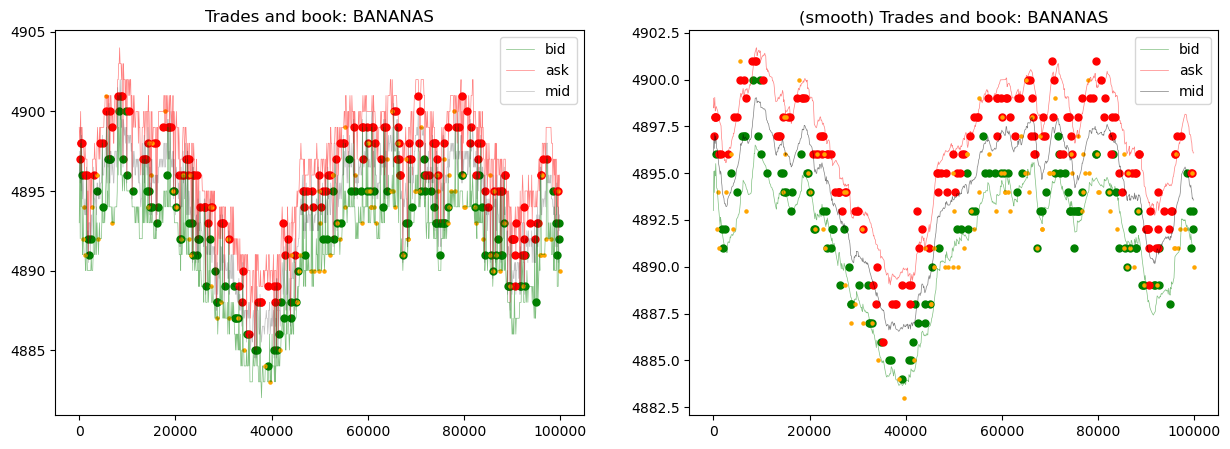

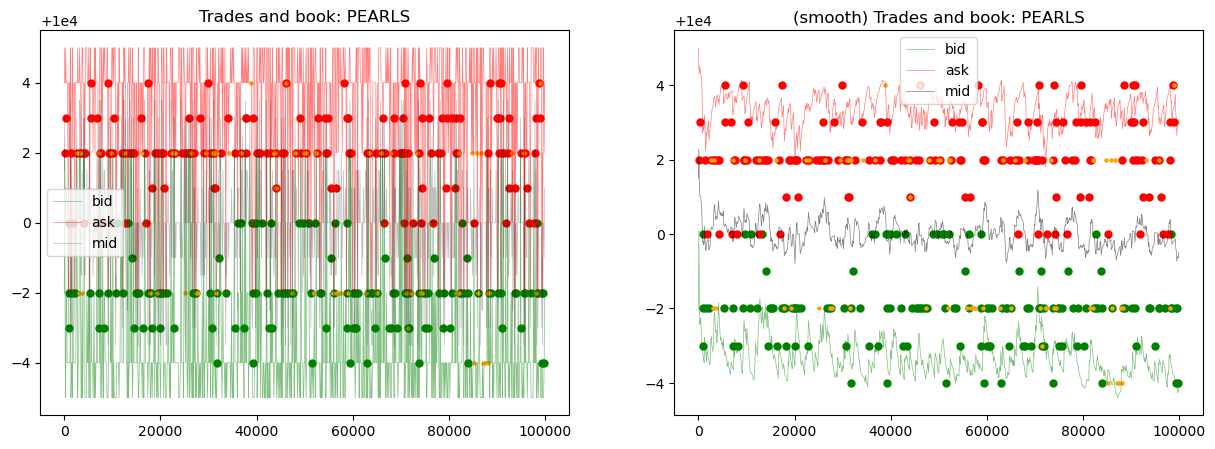

In [31]:
plot_trades_and_book(
    sym="BANANAS", 
    trade_df=trade_df, 
    book_df=book_tops, 
#     time_lb=0, 
#     time_ub=50000, 
    span=21,
    show_mid=True,
)
plot_trades_and_book(
    sym="PEARLS", 
    trade_df=trade_df, 
    book_df=book_tops, 
#     time_lb=0, 
#     time_ub=50000, 
    span=21,
    show_mid=True,
)


### compare ref EMA to true EMA

In [32]:
symbol = "BANANAS"
spans = raw_records["best_ema_spans"].apply(lambda x : x[symbol])
spans.value_counts()

21    998
Name: best_ema_spans, dtype: int64

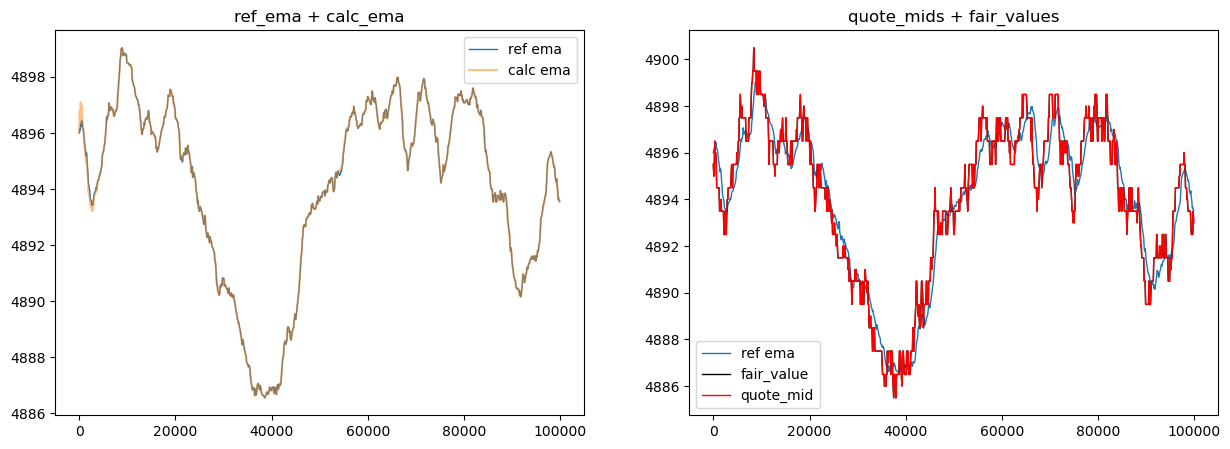

In [33]:
symbol = "BANANAS"

mids = book_tops[f"{symbol}_mid"]
ema = mids.ewm(span=21).mean()

plt.figure(figsize=(15, 5))

plt.subplot(121)

plt.plot(ref_emas["time"], ref_emas[symbol], label="ref ema", alpha=1, linewidth=1)
plt.plot(book_tops["time"], ema, label="calc ema", alpha=0.5)
plt.legend()
plt.title("ref_ema + calc_ema")

plt.subplot(122)

plt.plot(ref_emas["time"], ref_emas[symbol], label="ref ema", alpha=1, linewidth=1)
plt.plot(fair_values["time"], fair_values[symbol], label="fair_value", color="black", alpha=1, linewidth=1)
plt.plot(quote_mids["time"], quote_mids[symbol], label="quote_mid", color="red", alpha=1, linewidth=1)
plt.legend()
plt.title("quote_mids + fair_values")
plt.show()


In [34]:
# print times when not using quote_mids
for sym in _symbols:
    print(sym, use_quote_mids[~use_quote_mids[sym]]["time"].tolist())


BANANAS []
PEARLS []


### PNL Graph

Text(0.5, 1.0, 'PNL')

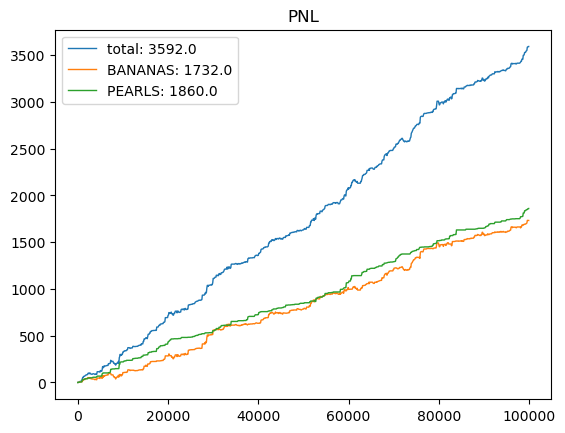

In [35]:
# pnl
for prod in ["total", *_products]:
    pnl = my_positions[f"{prod}_pnl"].iloc[-1]
    plt.plot(my_positions["time"], my_positions[f"{prod}_pnl"], label=f"{prod}: {pnl}", linewidth=1)
    
plt.legend()
plt.title(f"PNL")


### Positions Graph

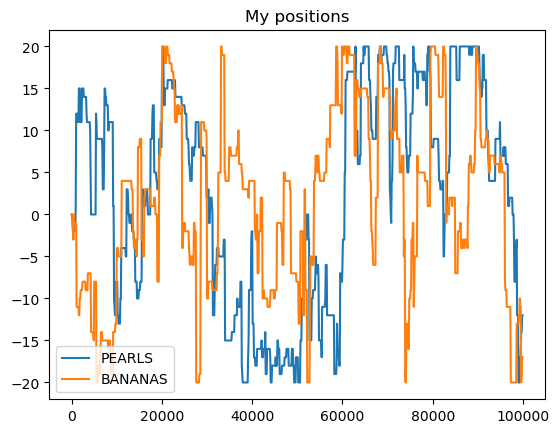

In [36]:
# plot my positions in each product

plt.plot(my_positions["time"], my_positions["PEARLS"], label="PEARLS")
plt.plot(my_positions["time"], my_positions["BANANAS"], label="BANANAS")
plt.title("My positions")
plt.legend()
plt.show()

### Price movements (pct change)

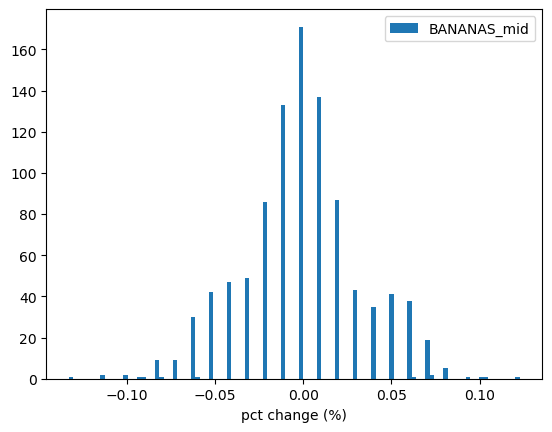

,count,mean,std,min,25%,50%,75%,max
BANANAS_mid,997.0,-0.000045,0.03445,-0.132734,-0.020421,0.0,0.020425,0.122687


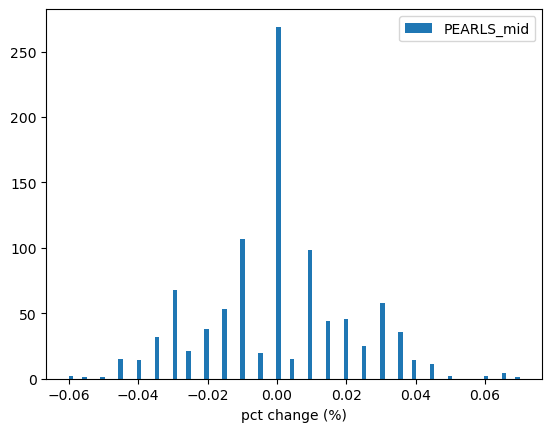

,count,mean,std,min,25%,50%,75%,max
PEARLS_mid,997.0,-0.000003,0.021171,-0.059982,-0.010002,0.0,0.010001,0.070025


In [37]:
# distribution of price movements (pct change)
mids = ["BANANAS_mid", "PEARLS_mid"]

for mid in mids:
    col = book_tops[[mid]]
    diffs = (col.shift(-1) / col).dropna()
    diffs = (diffs - 1) * 100
    plt.hist(diffs, bins=100, label=mid)
    plt.xlabel("pct change (%)")
    plt.legend()
    plt.show()
    display(diffs.describe().T)

### Price movements (actual change)

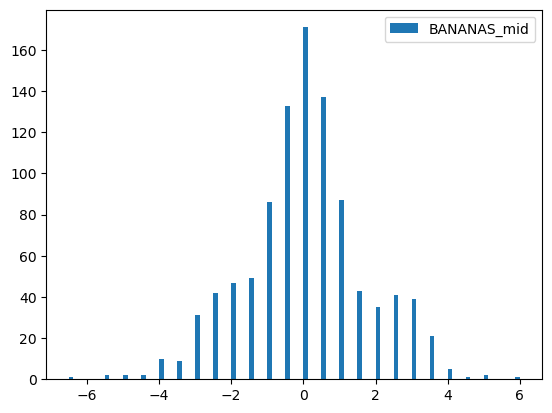

,count,mean,std,min,25%,50%,75%,max
BANANAS_mid,997.0,-0.002508,1.686005,-6.5,-1.0,0.0,1.0,6.0


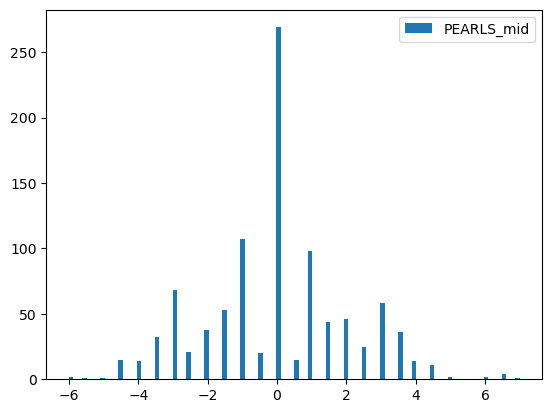

,count,mean,std,min,25%,50%,75%,max
PEARLS_mid,997.0,-0.000502,2.117116,-6.0,-1.0,0.0,1.0,7.0


In [38]:
# distribution of price movements (actual #)
mids = ["BANANAS_mid", "PEARLS_mid"]

for mid in mids:
    col = book_tops[[mid]]
    diffs = (col.shift(-1) - col).dropna()
    plt.hist(diffs, bins=100, label=mid)
    plt.legend()
    plt.show()
    display(diffs.describe().T)


### Spread stats - BANANAS

In [39]:
# spread summary stats

sym = "BANANAS"
spreads = pd.DataFrame(book_tops[f"{sym}_best_sell"] - book_tops[f"{sym}_best_buy"])
spreads.describe().T

,count,mean,std,min,25%,50%,75%,max
0,998.0,5.251503,1.945566,1.0,5.0,6.0,7.0,7.0


### Spread stats - PEARLS

In [40]:
# spread summary stats

sym = "PEARLS"
spreads = pd.DataFrame(book_tops[f"{sym}_best_sell"] - book_tops[f"{sym}_best_buy"])
spreads.describe().T

,count,mean,std,min,25%,50%,75%,max
0,998.0,6.671343,2.550631,2.0,6.0,7.5,8.0,10.0


In [41]:
# quantity stats
trade_df.groupby("time")[["quantity"]].sum().describe(percentiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]).T

,count,mean,std,min,1%,10%,25%,50%,75%,90%,99%,max
quantity,524.0,4.316794,4.269016,1.0,1.0,1.0,1.0,3.0,5.25,11.0,19.0,21.0


In [42]:
book_tops

,BANANAS_best_buy,BANANAS_best_sell,BANANAS_mid,BANANAS_spread,PEARLS_best_buy,PEARLS_best_sell,PEARLS_mid,PEARLS_spread,time
turn,,,,,,,,,
0,4893.0,4899.0,4896.0,6.0,9998.0,10005.0,10001.5,7.0,0
1,4897.0,4898.0,4897.5,1.0,10002.0,10004.0,10003.0,2.0,100
2,4892.0,4899.0,4895.5,7.0,9996.0,10004.0,10000.0,8.0,200
3,4898.0,4900.0,4899.0,2.0,9995.0,10005.0,10000.0,10.0,300
4,4894.0,4896.0,4895.0,2.0,9998.0,10004.0,10001.0,6.0,400
...,...,...,...,...,...,...,...,...,...
993,4889.0,4896.0,4892.5,7.0,9995.0,9998.0,9996.5,3.0,99500
994,4889.0,4892.0,4890.5,3.0,9995.0,10005.0,10000.0,10.0,99600
995,4892.0,4896.0,4894.0,4.0,9995.0,10005.0,10000.0,10.0,99700


In [43]:
book_top_df = book_tops.melt(id_vars=["time"])
cols = book_top_df["variable"].str.split("_", n=1).apply(pd.Series).set_axis(["symbol", "variable"], axis=1)

book_top_df = book_top_df.drop("variable", axis=1).join(cols)


In [44]:
book_top_df

,time,value,symbol,variable
0,0,4893.0,BANANAS,best_buy
1,100,4897.0,BANANAS,best_buy
2,200,4892.0,BANANAS,best_buy
3,300,4898.0,BANANAS,best_buy
4,400,4894.0,BANANAS,best_buy
...,...,...,...,...
7979,99500,3.0,PEARLS,spread
7980,99600,10.0,PEARLS,spread
7981,99700,10.0,PEARLS,spread
7982,99800,6.0,PEARLS,spread


###  taker vs maker stats

BANANAS - my TAKER pnl: 805.0


,count,mean,std,min,25%,50%,75%,max
my_edge,177.0,1.59887,0.920165,-1.0,1.5,1.5,2.5,2.5


BANANAS - my MAKER pnl: 979.5


,count,mean,std,min,25%,50%,75%,max
my_edge,91.0,1.967033,0.755727,-0.5,1.5,2.5,2.5,2.5


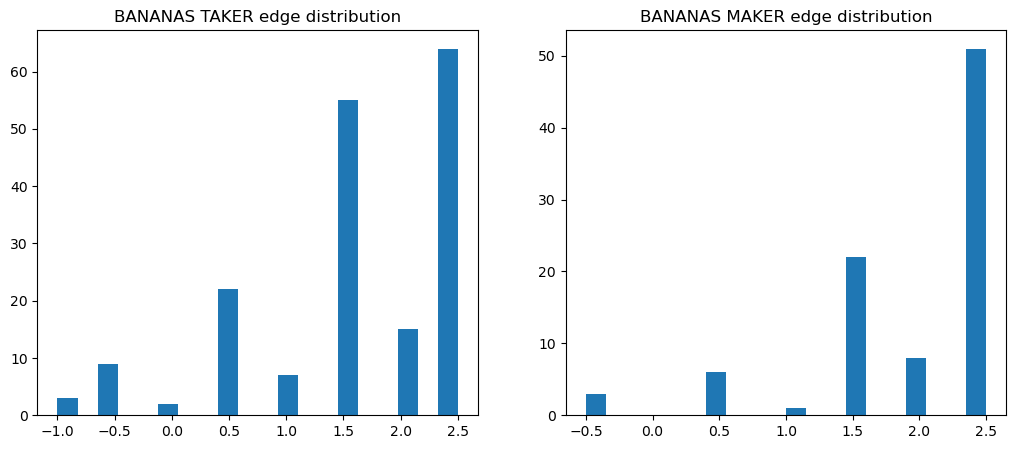

In [45]:
# merge current trades with previous turn's tops
my_trade_df = my_trades.copy()
my_trade_df["time"] -= _time_step

# get col to merge on
my_trade_df["variable"] = np.where(
    my_trade_df["my_buy"], 
    "best_sell", 
    "best_buy", 
)


my_trade_df = my_trade_df.merge(book_top_df, on=["time", "symbol", "variable"])

# if my buy price is greater than best sell price
# if my sell price is less than best buy price
my_trade_df["is_take"] = np.where(
    my_trade_df["my_buy"],
    my_trade_df["price"] >= my_trade_df["value"], # 
    my_trade_df["price"] <= my_trade_df["value"], # 
)


# drop cols
my_trade_df = my_trade_df.drop(["variable", "value"], axis=1)


# filter to keep only taker trades

# compute buy edge
my_trade_df["buy_edge"] = my_trade_df["fair_value"] - my_trade_df["price"]

# compute my edge
my_trade_df["my_edge"] = my_trade_df["buy_edge"] * np.sign(my_trade_df["my_quantity"])

# compute pnl
my_trade_df["pnl"] = my_trade_df["my_edge"] * my_trade_df["quantity"]

# filter by symbol
        
for sym in _symbols:
    the_df = my_trade_df[my_trade_df["symbol"] == sym]
    
    maker_df = the_df[~the_df["is_take"]]
    taker_df = the_df[the_df["is_take"]]
    

    # display pnl / stats for TAKER
    plt.figure(figsize=(12.5, 5))
    plt.subplot(121)
    print(sym, "- my TAKER pnl:", taker_df["pnl"].sum())

    display(taker_df[["my_edge"]].describe().T)

    plt.hist(taker_df[["my_edge"]], bins=20)
    plt.title(f"{sym} TAKER edge distribution")
    
    
    # display pnl / stats for MAKER
    plt.subplot(122)
    print(sym, "- my MAKER pnl:", maker_df["pnl"].sum())

    display(maker_df[["my_edge"]].describe().T)

    plt.hist(maker_df[["my_edge"]], bins=20)
    plt.title(f"{sym} MAKER edge distribution")
    plt.show()
    break

### taker/maker optimization


- deciding whether to take/make:
    - current inventory (estimated)
    - common
        - cur_pos
    - taker:
        - info:
            - edge, quantity
        - actions
            - take all/ignore
            - take up to quantity
        - transition
            - reward = edge * abs(taken_quantity)
            - new_pos = cur_pos + taken_quantity
    - maker:
        - info:
            - edge (the edge that we'd receive for placing an order at the best bid)
            - limit
        - actions
            - quantity up to limit
            
        - transition
            - randomized taken_quantity is selected
            - reward = edge * abs(taken_quantity)
            - new_pos = cur_pos + taken_quantity
- state:
    - current inventory (

In [46]:
def rollout_action(cur_pos, limit, act):
    """
    Performs action given cur_pospotential action `act`
    
    Returns new_pos, pnl_change
    """
    
    edge = act["edge"]
    quantity = act["quantity"]
    is_buy = act["is_buy"]

    if edge == 0:
        # only take if it's good for us
        if is_buy:
            quantity = min(quantity, 0 - cur_pos)
        else:
            quantity = min(quantity, 0 + cur_pos)
    else:
        # take maximum
        if is_buy:
            quantity = min(quantity, limit - cur_pos)
        else:
            quantity = min(quantity, limit + cur_pos)

    # update state
    pnl_change = quantity * edge
    quantity_change = quantity if is_buy else -1 * quantity

    return cur_pos + quantity_change, pnl_change



### monte-carlo sim
def rollout(cur_pdf, limit, action_df):
    """
    Runs one MC rollout using the specified params
    
    Returns pnl_per_turn, ending_position
    """
    
    all_pdf = {i: 0 for i in range(-limit, limit + 1)}
    all_pnl = 0
    
    for cur_pos, cur_pos_prob in cur_pdf.items():
        if cur_pos_prob == 0:
            continue

        
        pdf = {i: 0 for i in range(-limit, limit + 1)}
        # if we don't take any taker_df trades, we will remain in this position
        pdf[cur_pos] = 1 - action_df["freq"].sum()

        # trade_pnl will contain expected pnl from trading when we start at 'cur_pos'
        trade_pnl = 0

        # iterate through actions
        for index, row in action_df.iterrows():
            new_pos, pnl_diff = rollout_action(cur_pos, limit, row)

            # get pnl from trade
            trade_pnl += pnl_diff * row["freq"]
            pdf[new_pos] += row["freq"]
            
        # pnl contains total profits from edge up to this point
#         print("trade pnl", cur_pos, trade_pnl)
        
        # update all_pnl
        all_pnl += trade_pnl * cur_pos_prob
        
        # update all_pdf
        for next_pos, next_pos_prob in pdf.items():
            all_pdf[next_pos] += next_pos_prob * cur_pos_prob
            
    return all_pnl, all_pdf

In [77]:
# hyper-params
def get_markov_chain(sym, limit, rollout_length):

    num_turns = _max_time / _time_step

    # create taker_df
    taker_df = order_df[order_df["symbol"] == sym]
    taker_df = taker_df[taker_df["taker_edge"] >= 0]
    taker_df = taker_df[["quantity", "taker_edge"]].copy().rename({"taker_edge": "edge"}, axis=1)

    taker_df["is_buy"] = ~(taker_df["quantity"] > 0) # we can perform the opposite trade against this quantity
    taker_df["quantity"] = taker_df["quantity"].abs()
    taker_df["edge"] = taker_df["edge"].abs() # convert -0 to 0

    # create order_df
    the_df = my_trade_df[(my_trade_df["symbol"] == sym)]
    maker_df = the_df[~the_df["is_take"]]
    maker_df = maker_df[["quantity", "my_edge", "my_buy"]].rename({"my_buy": "is_buy", "my_edge": "edge"}, axis=1)

    # calculate pnl
    taker_df["pnl"] = taker_df["edge"] * taker_df["quantity"]
    maker_df["pnl"] = maker_df["edge"] * maker_df["quantity"]

    # print stats abt taker/maker

    print("taker chance", len(taker_df) / num_turns)
    print("maker chance", len(maker_df) / num_turns)
    print("market_trade chance", len(market_trades) / num_turns)

    # print taker profits

    print("Taker total edge by side")
    display(taker_df.groupby("is_buy")["pnl"].sum())

    print("Maker total edge by side")
    display(maker_df.groupby("is_buy")["pnl"].sum())



    # calculate taker stats
    taker_stats = taker_df.groupby(["quantity", "edge", "is_buy"]).value_counts().rename("freq").reset_index()
    taker_stats["freq"] /= num_turns

    maker_stats = maker_df.groupby(["quantity", "edge", "is_buy"]).value_counts().rename("freq").reset_index()
    maker_stats["freq"] /= num_turns

    print("len(taker_stats)", len(taker_stats))
    print("len(maker_stats)", len(maker_stats))


    ## calculate transition matrices
    trade_pnls = {}
    next_pdfs = {}

    for cur_pos in range(-limit, limit + 1):
        # setup initial cur_pdf
        cur_pdf = {i: 0 for i in range(-limit, limit + 1)}
        cur_pdf[cur_pos] = 1

        # rollout on taker
        taker_pnl, pdf1 = rollout(
            cur_pdf=cur_pdf,
            limit=limit,
            action_df=taker_stats,
        )

        # rollout on maker
        maker_pnl, pdf2 = rollout(
            cur_pdf=pdf1,
            limit=limit,
            action_df=maker_stats,
        )

        trade_pnls[cur_pos] = taker_pnl + maker_pnl
        next_pdfs[cur_pos] = pdf2

    # get A - transition probability matrix
    # a_ij is prob of going from j to i
    trans_prob_df = pd.DataFrame(next_pdfs)
    A = trans_prob_df.to_numpy()

    # each row should sum to 1
    assert np.all(abs(A.sum(axis=0) - 1) <= 1e-5)

    # get D - transition income matrix
    trans_pnl_df = pd.DataFrame(trade_pnls.items(), columns=["cur_pos", "pnl"])
    trans_pnl_df = trans_pnl_df.sort_values(by="cur_pos")

    D = trans_pnl_df["pnl"].to_numpy()

    return A, D

In [78]:
# calculate scores
def score_matrix(A, D, limit):
    scores = {}

    for cur_pos in range(-limit, limit + 1):
        # init cur_pdf
        cur_pdf = np.zeros((2 * limit + 1, 1))
        cur_pdf[cur_pos + limit, 0] = 1

        pnl = 0

        # iterate for rollout number of times
        for i in range(rollout_length):
            trade_pnl = np.dot(D, cur_pdf).item()
            cur_pdf = A @ cur_pdf

            pnl += trade_pnl

        scores[cur_pos] = pnl
        
    score_df = pd.DataFrame(scores.items(), columns=["start_pos", "pnl"])
    score_df = score_df.set_index("start_pos")
    score_df["pnl_diff"] = score_df["pnl"] - score_df["pnl"].loc[0]
    score_df["pnl_diff_rev"] = list(score_df["pnl_diff"].iloc[::-1])
    score_df["pnl_norm"] = (score_df["pnl_diff_rev"] + score_df["pnl_diff"]) / 2
    
    return score_df

In [79]:
rollout_length = 100
limit = 20

taker chance 0.181
maker chance 0.091
market_trade chance 0.175
Taker total edge by side


is_buy
False    330.0
True     466.0
Name: pnl, dtype: float64

Maker total edge by side


is_buy
False    512.5
True     467.0
Name: pnl, dtype: float64

len(taker_stats) 47
len(maker_stats) 46


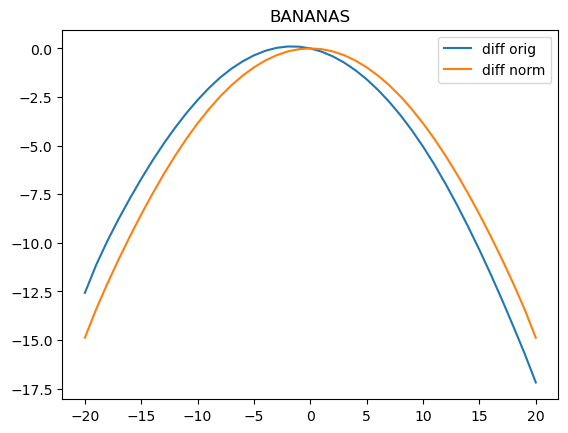

,pnl,pnl_diff,pnl_diff_rev,pnl_norm
start_pos,,,,
-20,141.245366,-12.574754,-17.179872,-14.877313
-19,142.684305,-11.135815,-15.681034,-13.408424
-18,143.925513,-9.894607,-14.284451,-12.089529
-17,145.056559,-8.763561,-12.922847,-10.843204
-16,146.111452,-7.708667,-11.613628,-9.661148
-15,147.112440,-6.707680,-10.361415,-8.534547
-14,148.052991,-5.767129,-9.174165,-7.470647
-13,148.928921,-4.891199,-8.037265,-6.464232
-12,149.740119,-4.080001,-6.969550,-5.524775


In [80]:
# show scores for each position
sym = "BANANAS"

A, D = get_markov_chain(
    sym=sym,
    limit=limit,
    rollout_length=rollout_length,
)
score_df = score_matrix(A, D, limit=limit)

plt.plot(score_df.index, score_df["pnl_diff"], label="diff orig")
plt.plot(score_df.index, score_df["pnl_norm"], label="diff norm")
plt.legend()
plt.title(sym)
plt.show()

display(score_df)

# save to file
opp_costs = score_df["pnl_norm"].to_dict()

with open(f"./opp_costs_{sym}.json", "w") as f:
    f.write(str(opp_costs))

taker chance 0.24
maker chance 0.105
market_trade chance 0.175
Taker total edge by side


is_buy
False    402.0
True     490.0
Name: pnl, dtype: float64

Maker total edge by side


is_buy
False    563.0
True     457.0
Name: pnl, dtype: float64

len(taker_stats) 29
len(maker_stats) 38


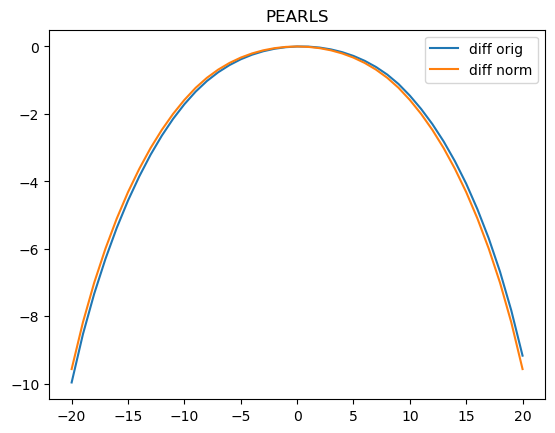

,pnl,pnl_diff,pnl_diff_rev,pnl_norm
start_pos,,,,
-20,175.474676,-9.963063,-9.167848,-9.565456
-19,176.904023,-8.533717,-7.826705,-8.180211
-18,178.104306,-7.333434,-6.677282,-7.005358
-17,179.139729,-6.298011,-5.689571,-5.993791
-16,180.058125,-5.379614,-4.829169,-5.104391
-15,180.868591,-4.569148,-4.067700,-4.318424
-14,181.585378,-3.852362,-3.403010,-3.627686
-13,182.226893,-3.210847,-2.815038,-3.012943
-12,182.793865,-2.643875,-2.301567,-2.472721


In [81]:
# show scores for each position
sym = "PEARLS"

A, D = get_markov_chain(
    sym=sym,
    limit=limit,
    rollout_length=rollout_length,
)
score_df = score_matrix(A, D, limit=limit)

plt.plot(score_df.index, score_df["pnl_diff"], label="diff orig")
plt.plot(score_df.index, score_df["pnl_norm"], label="diff norm")
plt.legend()
plt.title(sym)
plt.show()

display(score_df)

# save to file
opp_costs = score_df["pnl_norm"].to_dict()

with open(f"./opp_costs_{sym}.json", "w") as f:
    f.write(str(opp_costs))

### Available Taker edge

In [52]:
# calculate available taker edge

avail_taker_df = order_df[order_df["taker_edge"] > 0].copy()
avail_taker_df["pnl"] = avail_taker_df["taker_edge"] * avail_taker_df["quantity"].abs()

for sym in _symbols:
    df = avail_taker_df[avail_taker_df["symbol"] == sym]
    print(f"Available taker edge in {sym}", df["pnl"].sum().round())



Available taker edge in BANANAS 796.0
Available taker edge in PEARLS 892.0


### missed takers


In [53]:

# get avail taker trades + my taker trades
avail_df = avail_taker_df
my_df = my_trade_df[my_trade_df["is_take"]]

# filter columns
my_df = my_df[["time", "symbol", "price", "my_quantity"]]
avail_df = avail_df[["time", "symbol", "price", "quantity", "taker_edge", "fair_value"]]

# see which avail taker trades were actually taken by me
taker_df = avail_df.merge(my_df, how="left", on=["time", "symbol", "price"])

taker_df["my_quantity"] = taker_df["my_quantity"].fillna(0)

# ensure my_quantity is not the same sign of resting order quantity
wrongs = (taker_df["my_quantity"] == taker_df["quantity"])
assert(wrongs.sum() == 0)
# display(taker_df[wrongs])

# calculate taken vs avail size
taker_df["avail_size"] = taker_df["quantity"].abs()
taker_df["taken_size"] = np.minimum(taker_df["my_quantity"].abs(), taker_df["avail_size"])
taker_df["missed_size"] = taker_df["avail_size"] - taker_df["taken_size"]

# calculate taken vs avail pnl
taker_df["avail_pnl"] = taker_df["taker_edge"] * taker_df["avail_size"]
taker_df["taken_pnl"] = taker_df["taker_edge"] * taker_df["taken_size"]
taker_df["missed_pnl"] = taker_df["taker_edge"] * taker_df["missed_size"]

for sym in _symbols:
    df = taker_df[taker_df["symbol"] == sym]
    
    print(sym, "taken_pnl", df["taken_pnl"].sum())
    print(sym, "avail_pnl", df["avail_pnl"].sum())
    print(sym, "missed_pnl", df["missed_pnl"].sum())
    print()
    print(sym, "taken_size", df["taken_size"].sum())
    print(sym, "avail_size", df["avail_size"].sum())
    print(sym, "missed_size", df["missed_size"].sum())
    print()


BANANAS taken_pnl 693.5
BANANAS avail_pnl 796.0
BANANAS missed_pnl 102.5

BANANAS taken_size 395.0
BANANAS avail_size 471
BANANAS missed_size 76.0

PEARLS taken_pnl 824.0
PEARLS avail_pnl 892.0
PEARLS missed_pnl 68.0

PEARLS taken_size 412.0
PEARLS avail_size 446
PEARLS missed_size 34.0



In [54]:
# missed takers
my_pos_df = my_positions.melt(id_vars=["time"], value_vars=_symbols, var_name="symbol", value_name="cur_pos")

untaken_df = taker_df[taker_df["avail_size"] != taker_df["taken_size"]]

# untaken_df = untaken_df[["time", "symbol", "price", "fair_value", "taker_edge", "avail_size", "taken_size"]].merge(my_pos_df, on=["time", "symbol"])
untaken_df = untaken_df.merge(my_pos_df, on=["time", "symbol"])

for sym in _symbols:
    df = untaken_df[untaken_df["symbol"] == sym].drop(["my_quantity"], axis=1)
    
    display(df)
    
    

,time,symbol,price,quantity,taker_edge,fair_value,avail_size,taken_size,missed_size,avail_pnl,taken_pnl,missed_pnl,cur_pos
0,5700,BANANAS,4899,4,1.0,4898.0,4,0.0,4.0,4.0,0.0,4.0,-20.0
1,14800,BANANAS,4896,-4,0.5,4896.5,4,0.0,4.0,2.0,0.0,2.0,8.0
2,20000,BANANAS,4894,-12,2.5,4896.5,12,9.0,3.0,30.0,22.5,7.5,11.0
4,21000,BANANAS,4892,-13,2.5,4894.5,13,1.0,12.0,32.5,2.5,30.0,19.0
5,21000,BANANAS,4894,-5,0.5,4894.5,5,0.0,5.0,2.5,0.0,2.5,19.0
6,23300,BANANAS,4893,-4,1.0,4894.0,4,2.0,2.0,4.0,2.0,2.0,11.0
10,50000,BANANAS,4893,2,0.5,4892.5,2,0.0,2.0,1.0,0.0,1.0,-8.0
12,50200,BANANAS,4894,7,1.0,4893.0,7,5.0,2.0,7.0,5.0,2.0,-8.0
13,57200,BANANAS,4896,-2,0.5,4896.5,2,0.0,2.0,1.0,0.0,1.0,8.0
14,61100,BANANAS,4895,-4,2.5,4897.5,4,2.0,2.0,10.0,5.0,5.0,18.0


,time,symbol,price,quantity,taker_edge,fair_value,avail_size,taken_size,missed_size,avail_pnl,taken_pnl,missed_pnl,cur_pos
3,20100,PEARLS,9998,-4,2.0,10000.0,4,3.0,1.0,8.0,6.0,2.0,17.0
7,38600,PEARLS,10002,1,2.0,10000.0,1,0.0,1.0,2.0,0.0,2.0,-20.0
8,44000,PEARLS,10002,4,2.0,10000.0,4,3.0,1.0,8.0,6.0,2.0,-17.0
9,49200,PEARLS,10002,3,2.0,10000.0,3,2.0,1.0,6.0,4.0,2.0,-18.0
11,50100,PEARLS,10002,4,2.0,10000.0,4,3.0,1.0,8.0,6.0,2.0,-17.0
17,64900,PEARLS,9998,-4,2.0,10000.0,4,1.0,3.0,8.0,2.0,6.0,19.0
20,71800,PEARLS,9998,-1,2.0,10000.0,1,0.0,1.0,2.0,0.0,2.0,20.0
21,72100,PEARLS,9998,-1,2.0,10000.0,1,0.0,1.0,2.0,0.0,2.0,20.0
22,72200,PEARLS,9998,-1,2.0,10000.0,1,0.0,1.0,2.0,0.0,2.0,20.0
24,75600,PEARLS,9998,-9,2.0,10000.0,9,6.0,3.0,18.0,12.0,6.0,14.0


### Available maker edge

In [55]:
# calculate market maker edge (maker edge that the market received)
maker_df = market_trades.copy()

maker_df["edge"] = maker_df["buy_edge"].abs()
maker_df["pnl"] = maker_df["quantity"] * maker_df["edge"]

for sym in _symbols:
    df = maker_df[maker_df["symbol"] == sym]
    print(f"Remaining maker edge in {sym}", df["pnl"].sum().round())
    

Remaining maker edge in BANANAS 561.0
Remaining maker edge in PEARLS 329.0


## Trade analysis - BANANAS

#### func - calc_rtns()

In [56]:
# find performance of trades after 1 tick, 10 ticks, 100 ticks
# returns only my trades for the specified symbol
def calc_rtns(trade_df, sym, waits):
    global fairs
    
    df = trade_df
    df = df[df["symbol"] == sym]
    df = df[df["is_me"]]
    
    # exclude trades during "closing time"
    cutoff_time = _max_time - _num_close_turns * _time_step
    df = df[df["time"] < cutoff_time]

    for wait in waits:
        suffix = f"_{wait}"

        # get shifted fairs
        fairs_shift = fairs.set_index("time").shift(-1 * wait).ffill().bfill().add_suffix(suffix)
        fairs_shift = fairs_shift.reset_index()

        df = pd.merge(df, fairs_shift)

    for wait in waits:
        df[f"rtn_{wait}"] = (df[f"{sym}_{wait}"] - df["price"]) * np.sign(df["my_quantity"])

    return df



#### func - blur()

In [57]:
def blur(df, mu=0, std=0.1):
    noise = np.random.normal(loc=mu, scale=std, size=df.shape)
    return df + noise

### Rtn over time

total profit 1722.0


,count,mean,std,min,25%,50%,75%,max
rtn_-1,260.0,1.746154,0.860426,-1.0,1.500,2.0,2.5,2.5
rtn_0,260.0,1.751923,0.890206,-1.5,1.500,1.5,2.5,3.5
rtn_1,260.0,1.755769,0.957074,-1.5,1.500,1.5,2.5,3.5
rtn_3,260.0,1.759615,1.097955,-1.5,1.000,1.5,2.5,4.5
rtn_10,260.0,1.713462,1.588937,-2.5,0.500,1.5,2.5,6.5
rtn_30,260.0,1.794231,2.326813,-4.5,0.375,1.5,3.5,8.0
rtn_100,260.0,1.792308,3.766231,-5.5,-1.000,1.5,4.5,10.0


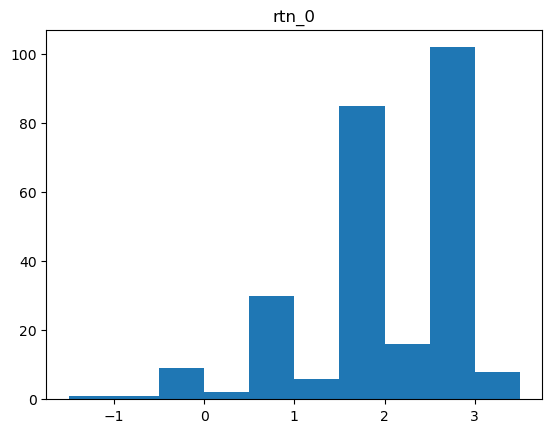

In [58]:
# summary stats for trades vs rtns

sym = "BANANAS"
waits=[-1, 0, 1, 3, 10, 30, 100]

df = calc_rtns(trade_df, sym=sym, waits=waits)
plt.hist(df["rtn_0"])
plt.title("rtn_0")

df["rtn_0_total"] = df["rtn_0"] * df["quantity"]

print("total profit", df["rtn_0_total"].sum())

display(df[[f"rtn_{wait}" for wait in waits]].describe().T)

### rtn vs quantity graph

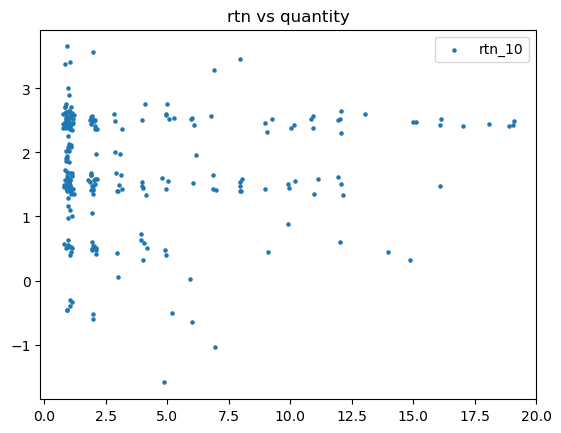

In [59]:
plt.scatter(blur(df["quantity"], std=0.1), blur(df["rtn_0"], std=0.1), s=5, label="rtn_10")
plt.title("rtn vs quantity")
plt.legend()
plt.show()



### large trades

In [60]:
# print out large trades

sizes = df.groupby("time")[["quantity"]].sum()
big_days = sizes[sizes["quantity"] >= 15]
df[df["time"].isin(big_days.index)]

,buyer,price,quantity,seller,symbol,order_time,time,turn,is_me,my_buy,...,BANANAS_100,PEARLS_100,rtn_-1,rtn_0,rtn_1,rtn_3,rtn_10,rtn_30,rtn_100,rtn_0_total
47,SUBMISSION,4895.0,15,,BANANAS,19300,19400,194,True,True,...,4890.5,10000.0,1.5,2.5,2.5,1.5,0.5,-0.5,-4.5,37.5
65,,4896.0,17,SUBMISSION,BANANAS,24400,24500,244,True,False,...,4887.5,10000.0,2.5,2.5,3.0,3.5,3.5,4.5,8.5,42.5
76,,4894.0,18,SUBMISSION,BANANAS,27500,27600,275,True,False,...,4886.5,10000.0,2.5,2.5,2.5,2.5,3.5,4.5,7.5,45.0
78,SUBMISSION,4888.0,19,,BANANAS,28500,28600,285,True,True,...,4886.5,10000.0,2.5,2.5,2.5,2.5,2.5,3.0,-1.5,47.5
82,,4893.0,19,SUBMISSION,BANANAS,29900,30000,299,True,False,...,4886.5,10000.0,2.5,2.5,2.5,2.5,2.5,4.5,6.5,47.5
88,SUBMISSION,4887.0,15,,BANANAS,33000,33100,330,True,True,...,4889.0,10000.0,1.5,0.5,0.5,1.5,0.5,-0.5,2.0,7.5
101,,4889.0,11,SUBMISSION,BANANAS,40500,40600,405,True,False,...,4893.5,10000.0,1.5,2.5,2.5,2.5,1.5,-0.5,-4.5,27.5
102,SUBMISSION,4885.0,5,,BANANAS,40500,40600,405,True,True,...,4893.5,10000.0,2.5,1.5,1.5,1.5,2.5,4.5,8.5,7.5
129,SUBMISSION,4892.0,15,,BANANAS,51500,51600,515,True,True,...,4896.0,10000.0,2.5,2.5,2.5,2.5,2.5,3.5,4.0,37.5
170,SUBMISSION,4893.0,16,,BANANAS,67800,67900,677,True,True,...,4897.5,10000.0,2.0,2.5,2.5,2.5,3.5,4.5,4.5,40.0


### losers: trade/book graph

In [61]:
losers = df[(df["rtn_10"] < 0)]
winners = df[df["rtn_10"] > 0]

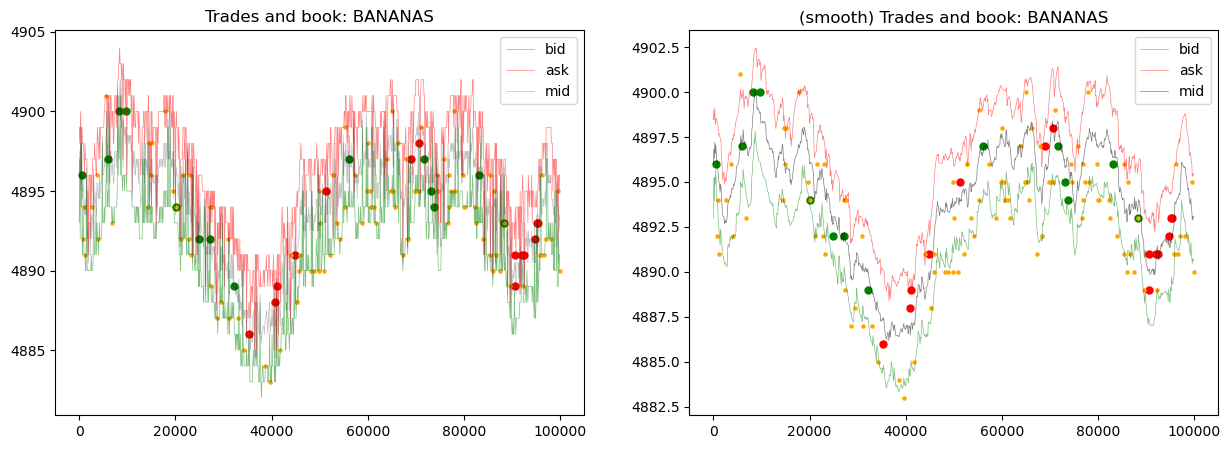

In [62]:
plot_trades_and_book(
    sym="BANANAS", 
    trade_df=pd.concat([losers, market_trades], axis=0), 
    book_df=book_tops, 
    time_lb=0, 
    time_ub=2e5, 
    span=10,
    show_mid=True,
)


In [63]:
losers

,buyer,price,quantity,seller,symbol,order_time,time,turn,is_me,my_buy,...,BANANAS_100,PEARLS_100,rtn_-1,rtn_0,rtn_1,rtn_3,rtn_10,rtn_30,rtn_100,rtn_0_total
3,SUBMISSION,4896.0,3,,BANANAS,400,500,5,True,True,...,4898.0,10000.0,0.0,0.0,-0.5,-1.5,-2.5,-1.5,2.0,0.0
16,SUBMISSION,4897.0,2,,BANANAS,5800,5900,59,True,True,...,4895.5,10000.0,0.5,1.0,0.5,0.5,-0.5,2.5,-1.5,2.0
22,SUBMISSION,4900.0,1,,BANANAS,8200,8300,83,True,True,...,4897.5,10000.0,-0.5,-0.5,0.5,-0.5,-1.5,-2.5,-2.5,-0.5
26,SUBMISSION,4900.0,1,,BANANAS,9600,9700,97,True,True,...,4896.5,10000.0,-1.0,-0.5,-1.5,-1.5,-1.5,-4.5,-3.5,-0.5
49,SUBMISSION,4894.0,9,,BANANAS,20000,20100,201,True,True,...,4890.5,10000.0,2.5,1.5,2.5,1.5,-0.5,0.5,-3.5,13.5
67,SUBMISSION,4892.0,1,,BANANAS,24800,24900,248,True,True,...,4887.5,10000.0,0.5,0.5,0.5,1.0,-0.5,-0.5,-4.5,0.5
74,SUBMISSION,4892.0,5,,BANANAS,27000,27100,270,True,True,...,4887.5,10000.0,0.0,-0.5,0.0,0.0,-0.5,-1.5,-4.5,-2.5
85,SUBMISSION,4889.0,2,,BANANAS,32100,32200,321,True,True,...,4890.5,10000.0,1.5,0.5,0.5,-0.5,-1.5,-2.5,1.5,1.0
93,,4886.0,1,SUBMISSION,BANANAS,35200,35300,352,True,False,...,4891.5,10000.0,-0.5,-0.5,-0.5,-0.0,-1.0,-0.5,-5.5,-0.5
103,,4888.0,1,SUBMISSION,BANANAS,40700,40800,407,True,False,...,4893.5,10000.0,1.5,1.5,1.5,0.5,-0.5,-1.5,-5.5,1.5


## Trade analysis - PEARLS

### rtn over time

total prof 1733.0


,count,mean,std,min,25%,50%,75%,max
rtn_-1,296.0,2.043919,0.9888,-0.0,2.0,2.0,3.0,4.0
rtn_0,296.0,2.043919,0.9888,-0.0,2.0,2.0,3.0,4.0
rtn_1,296.0,2.043919,0.9888,-0.0,2.0,2.0,3.0,4.0
rtn_3,296.0,2.043919,0.9888,-0.0,2.0,2.0,3.0,4.0
rtn_10,296.0,2.043919,0.9888,-0.0,2.0,2.0,3.0,4.0
rtn_30,296.0,2.043919,0.9888,-0.0,2.0,2.0,3.0,4.0
rtn_100,296.0,2.043919,0.9888,-0.0,2.0,2.0,3.0,4.0


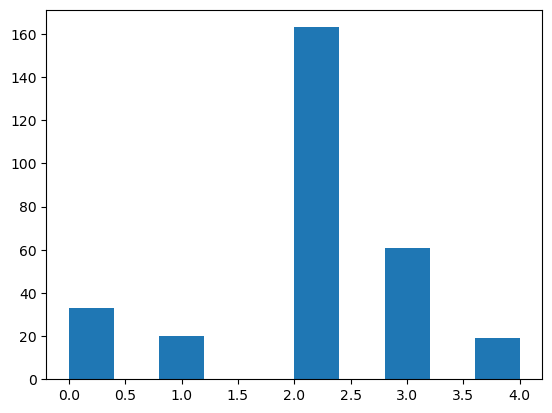

In [64]:
### summary stats for trades vs rtns

sym = "PEARLS"
waits=[-1, 0, 1, 3, 10, 30, 100]

df = calc_rtns(trade_df, sym=sym, waits=waits)
plt.hist(df["rtn_0"])

df["rtn_0_total"] = df["rtn_0"] * df["quantity"]

print("total prof", df["rtn_0_total"].sum())

display(df[[f"rtn_{wait}" for wait in waits]].describe().T)

### rtn vs quantity graph

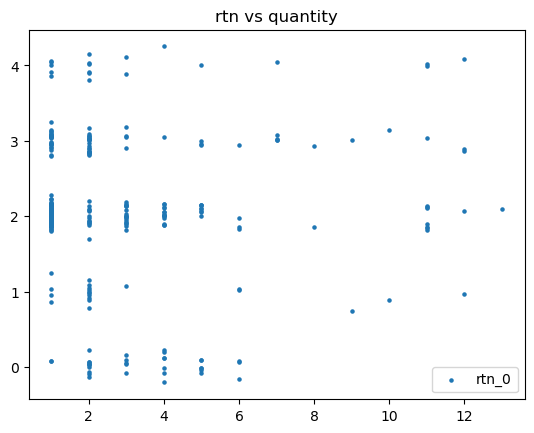

In [65]:
plt.scatter(blur(df["quantity"], std=0.0), blur(df["rtn_0"], std=0.1), s=5, label="rtn_0")
# plt.scatter(blur(df["quantity"]), blur(df["rtn_100"]), s=5, label="rtn_100")
plt.title("rtn vs quantity")
plt.legend()
plt.show()



### losers: rtn0 vs spread

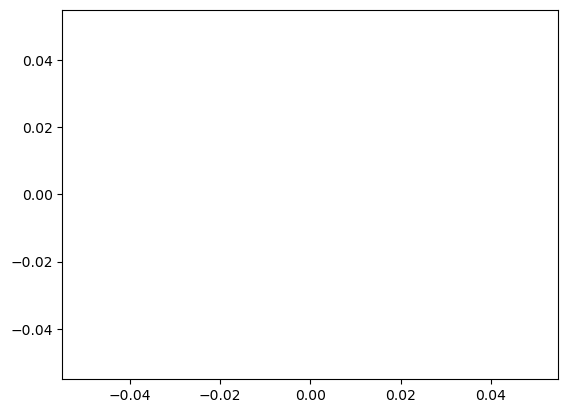

In [66]:
losers = df[(df["rtn_0"] < 0)]
winners = df[df["rtn_0"] > 0]

df = pd.merge(losers, book_tops[["BANANAS_spread", "time"]].shift(1), on="time")
plt.scatter(blur(df["BANANAS_spread"]), blur(df["rtn_0"]), s=5)

In [67]:
losers.describe().T

,count,mean,std,min,25%,50%,75%,max
price,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
quantity,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
order_time,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
time,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
turn,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
my_quantity,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ref_ema,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
quote_mid,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fair_value,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
buy_edge,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### losers: histogram of price changes

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

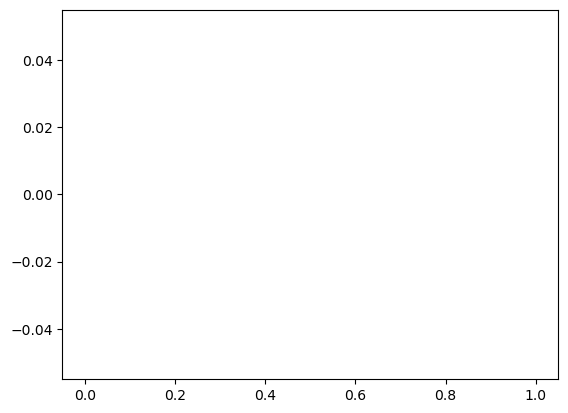

In [68]:
loser_diffs = (abs(losers["PEARLS_-1"] - losers["PEARLS_0"]))

plt.hist(loser_diffs)

### losers: trade/book graph

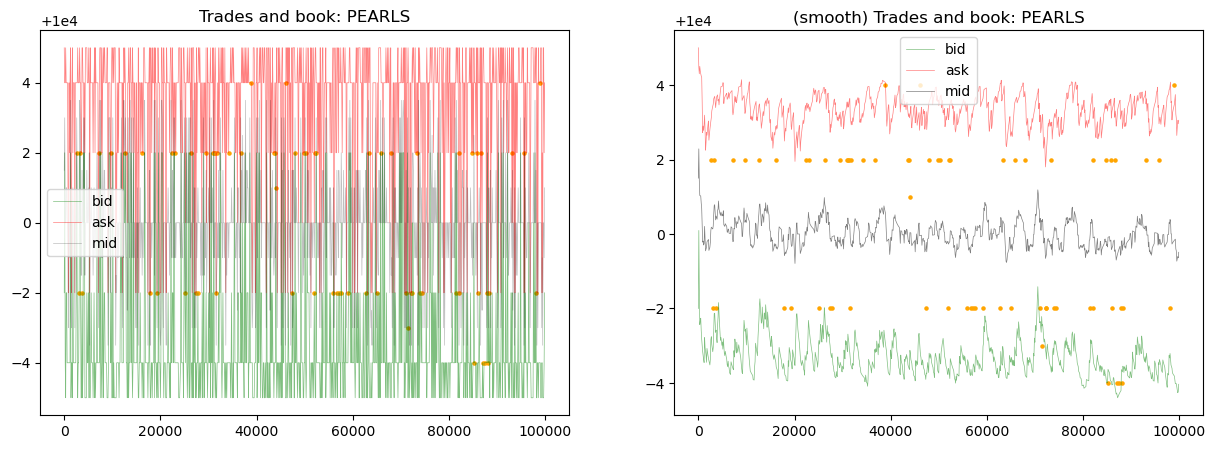

In [69]:
plot_trades_and_book(
    sym="PEARLS", 
    trade_df=pd.concat([losers, market_trades], axis=0), 
    book_df=book_tops, 
    time_lb=0, 
    time_ub=100000, 
    span=21,
    show_mid=True,
)
